# Simulation of the growth and development of an apple tree

## Loading meteo data

In [40]:
# Loading meteo data
import meteo ; reload(meteo)
from meteo import *
init_temperatures()

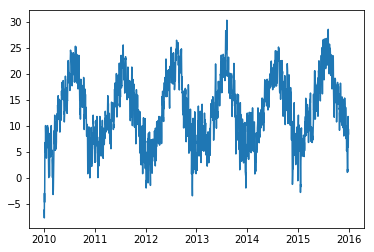

In [41]:
# Example of Use

get_temperature(date(2010,1,1))

from matplotlib.pyplot import plot, show

plot(get_all_dates(), get_all_temperatures())
show()

## Modelling thermal time

Thermal time consists in accumulating each day the temperature above a given threshold. 

In [4]:
base_temperature = 5

class ThermalTime:
    def __init__(self, base_temperature):
        self.base_temperature = base_temperature
    def get_effective_temperature(self, cdate):
        ctemp = get_temperature(cdate)
        return max(0, ctemp-self.base_temperature)
    def get_effective_temperatures(self, beg_date, end_date):
        return [max(0,ctemp-self.base_temperature) for ctemp in get_temperatures(beg_date, end_date)]

mthermaltime = ThermalTime(base_temperature)

### Organ production

The rate of production of metamer by an apex is given with the following equation

$R_i(d) = r_i x T_{eff}(d)$ if $N_i(d)<N_{f,i}$ and $d < D_e$

       = 0 else

with $r_i$ the rate of metamer production in thermal time, $T_{eff}(d)$ the accumulated thermal time at date $d$, $N_{f,i}$ the final number of metamer and $D_e$ the date of plant growth arrest.

In [42]:
metamerprodrate = 0.05
date_end_production = 252

In [43]:
class MetamerProduction:
    def __init__(self, rate, nbfinalmetamer, maxdate = date_end_production):
        self.rate = rate
        self.nbfinalmetamer = nbfinalmetamer
        self.nbmetamer = 0
        self.maxdate = maxdate
        
    def accumulate(self, cdate):
        ttime = mthermaltime.get_effective_temperature(cdate)
        if self.nbmetamer < self.nbfinalmetamer and (cdate -date(cdate.year,1,1)).days < self.maxdate :
            production = self.rate*ttime
            prevnbmetamer = int(self.nbmetamer)
            self.nbmetamer += production
            if int(self.nbmetamer) >  prevnbmetamer:
                return int(self.nbmetamer) - prevnbmetamer
            return 0
        return 0

## Organ final size

We distinguish the organ produced at the begining of the growth unit (preformed) from the other ones.

In [44]:
# Parameters
FinalLeafArea1 = 12.
FinalLeafArea2 = 25.

InternodeLength1 = 1
InternodeLength2 = 2.5

InternodeRadius = 0.3 

In [45]:
def leaf_area(rank):
    if rank < 7:
        return FinalLeafArea1
    else:
        return FinalLeafArea2

def internode_length(rank):
    if rank < 7:
        return InternodeLength1
    else:
        return InternodeLength2        

## Organ expansion

Growth will be modelled with a logistic function of the shape.

<center>
$ s(t) = \frac{A}{1+exp^{-\frac{t-t_{ip}}{b}}}$
</center>

With $A$ the maximum size, $t_{ip}$ the time at inflexion point and $b$ a slope parameter.
Its derivatives that gives the rate of growth will be

<center>
$ \frac{ds}{dt} = \frac{A.exp^{-\frac{t-t_{ip}}{b}} }{ b.(1+exp^{-\frac{t-t_{ip}}{b}})^2}$
</center>


In [10]:
from math import exp

def growth_logistic(ttime, finalsize, tip, b):
    return finalsize / (1 + exp(-(ttime-tip)/b ))

def growth_logistic_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_logistic(ttime, finalsize, tip, b)

def growth_rate(ttime, finalsize, tip, b):
    g = exp(-(ttime-tip)/b )
    return (finalsize * g)  / ( b * pow((1+g),2))


def growth_rate_at_date(begdate, cdate, finalsize, tip, b):
    ttime = sum(mthermaltime.get_effective_temperatures(begdate, cdate))
    return growth_rate(ttime, finalsize, tip, b)

We can parameterize the previous with the following value for the leaf and internode.

In [9]:
# Parameters
tip_leaf = 100.
tip_internode = 100.

b_leaf = 30.
b_internode = 30.

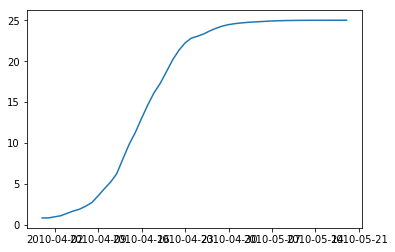

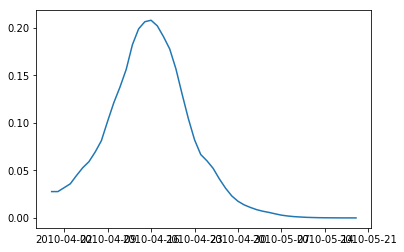

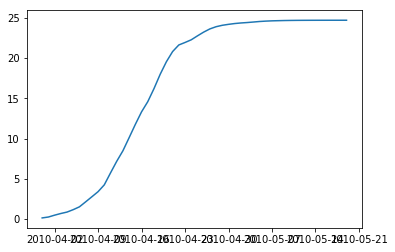

In [11]:
# Example of Use
begdate = date(2010,4,1)
growthperiod = [begdate+timedelta(days=i-1) for i in xrange(50)]

plot(growthperiod, map(lambda d : growth_logistic_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
show()

rate = list(map(lambda d : growth_rate_at_date(begdate, d, FinalLeafArea2, tip_leaf, b_leaf), growthperiod))
plot(growthperiod, rate)
show()

from numpy import dot, cumsum
integration = [a*b for a,b in zip(mthermaltime.get_effective_temperatures(begdate, begdate+timedelta(days=50)),rate)]
plot(growthperiod, cumsum(integration))
show()

## Growth unit length

In [46]:
from namedenum import enum
enum('ShortGU', 'MediumGU', 'LongGU', 'Inflo', 'TrunkGU', 'Blind', 'SyllepticShort', 'SyllepticMedium', 'SyllepticLong')

gulengthlaw = { ShortGU : (5, 0.5),
                MediumGU : (12, 3.5),
                LongGU : (28, 12.2),
                Inflo : (3, 0.2),
                TrunkGU : (50, 6.5)}

from random import gauss

def growth_unit_length(gutype):
    mean, sd = gulengthlaw[gutype]
    return gauss(mean,sd)

## Growth unit succession and flowering among years

In [47]:
sucessiontypes = [ShortGU, MediumGU, LongGU, Inflo]
successionmatrix = [[0.45, 0.1, 0.05, 0.4],
                    [0.4, 0.15, 0.05, 0.4],
                    [0.25, 0.25, 0.1, 0.4],
                    [0.65, 0.3, 0.05, 0]
                   ]
from random import uniform
from numpy import cumsum

def realization_in_probaranges(probas):
    cumsum_probs = cumsum(probas)
    totalprob = cumsum_probs[-1]
    cumsum_probs /= totalprob
    assert abs(cumsum_probs[-1] -1) < 1e-5
    unif_realization = float( uniform(0,1) )
    i = 0
    while unif_realization >= cumsum_probs[i] : i += 1
    return i

def succession(gutype):
    if gutype == TrunkGU : return LongGU
    probas = successionmatrix[gutype]
    return sucessiontypes[realization_in_probaranges(probas)]


In [48]:
# Example of Use

print growth_unit_length(ShortGU)
print succession(LongGU)
print succession(Inflo)

4.19159160477
Inflo
ShortGU


## Branching probability

In [49]:
lateraltypes = [Blind, ShortGU, MediumGU, LongGU, Inflo, SyllepticShort, SyllepticMedium, SyllepticLong]

branchingmatrixlong = [[0.7,0.3,0.05,0.05,0,0,0,0],
[0.5,0.2,0.15,0.05,0,0,0,0],
[0.6,0.3,0.1,0,0,0,0,0],
[0.9,0.1,0,0,0,0,0,0],
[0.6,0.1,0,0,0,0.05,0.05,0.05],
[0.6,0.1,0.1,0,0,0.05,0.05,0],
[0.55,0.1,0,0,0.3,0.03,0,0],
[0.55,0.05,0.1,0.05,0.2,0.02,0,0],
[0.4,0.1,0.2,0.2,0.1,0,0,0],
[0.75,0.1,0.1,0.05,0,0,0,0]]

branchingmatrixmedium = [[0.7,0.3,0.05,0.05,0,0,0,0],
[0.5,0.2,0.15,0.05,0,0,0,0],
[0.6,0.3,0.1,0,0,0,0,0],
[0.9,0.1,0,0,0,0,0,0],
[0.6,0.1,0,0,0,0.05,0.05,0.05],
[0.6,0.1,0.1,0,0,0.05,0.05,0],
[0.55,0.1,0,0,0.3,0.03,0,0],
[0.55,0.05,0.1,0.05,0.2,0.02,0,0],
[0.4,0.1,0.2,0.2,0.1,0,0,0],
[0.75,0.1,0.1,0.05,0,0,0,0]]


def branching(gutype, u):
    i, _ = divmod(u, 0.1)
    if gutype in [ShortGU,Inflo] : return Blind
    branchingmatrix = branchingmatrixlong if gutype in [TrunkGU,LongGU] else branchingmatrixmedium
    probas = branchingmatrix[int(i)]
    return lateraltypes[realization_in_probaranges(probas)]


    

In [50]:
# Example of Use

print branching(LongGU, 0.5)

Blind


# Architecture simulation

